# Seaborn-based Correlation Exploration

Helper notebook to explore correlations between variables using seaborn visualizations.

Features:
- Safe data loading (treats `?` as missing / NaN)
- Correlation matrix computation (Pearson / Spearman / Kendall)
- Heatmap + clustermap for correlation structure
- Pairplots (sampled) and jointplots for pairwise relationships
- Categorical vs target heatmaps
- Utility to compute correlations with a binary/numeric target

Usage: update DATA_PATH to point to your CSV (default `diabetic_data.csv`), run the cells, then run the example usage cell at the bottom.


In [7]:
# Install dependencies if needed (uncomment to run once)
# !pip install pandas numpy seaborn matplotlib scikit-learn

import os
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats  # new: statistics for chi2 / pointbiserial

sns.set(style="whitegrid")
DEFAULT_CMAP = "vlag"

# Configuration
DATA_PATH = "C:/Users/reinacherc/Downloads/diabetes+130-us+hospitals+for+years+1999-2008 (1)/diabetic_data.csv"  # change to your path
PLOT_DIR = "../eda_plots"
RANDOM_STATE = 42
os.makedirs(PLOT_DIR, exist_ok=True)


In [8]:

def compute_numeric_columns(df: pd.DataFrame) -> List[str]:
    # return the list of columns with numeric dtypes (used for correlation calculations)
    return df.select_dtypes(include=[np.number]).columns.tolist()

def corr_matrix(df: pd.DataFrame, cols: Optional[List[str]] = None, method: str = "pearson") -> pd.DataFrame:
    # if no columns provided, automatically pick numeric columns
    if cols is None:
        cols = compute_numeric_columns(df)
    # compute pairwise correlation matrix using requested method
    mat = df[cols].corr(method=method)
    return mat

def plot_corr_heatmap(
    corr: pd.DataFrame,
    title: str = "Correlation heatmap",
    annot: bool = True,
    fmt: str = ".2f",
    vmax: float = 1.0,
    vmin: float = -1.0,
    cmap: str = DEFAULT_CMAP,
    fname: Optional[str] = None,
    figsize: Tuple[int, int] = (12, 10),
    mask_upper: bool = True,
):
    # create a figure sized for readability
    plt.figure(figsize=figsize)
    # optionally mask upper triangle to avoid duplicate correlations in symmetric matrix
    mask = np.triu(np.ones_like(corr, dtype=bool)) if mask_upper else None
    # draw heatmap: center at 0 makes positive/negative correlations visually symmetric
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=vmax,
        vmin=vmin,
        center=0,
        square=False,
        linewidths=0.5,
        annot=annot,
        fmt=fmt,
        cbar_kws={"shrink": 0.6},
    )
    plt.title(title)
    plt.tight_layout()
    # save to file if filename provided
    if fname:
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def plot_clustermap(
    corr: pd.DataFrame,
    title: str = "Correlation clustermap (hierarchical)",
    cmap: str = DEFAULT_CMAP,
    fname: Optional[str] = None,
    figsize: Tuple[int, int] = (12, 12),
):
    # clustermap performs hierarchical clustering on correlation matrix to show blocks
    try:
        cg = sns.clustermap(
            corr,
            cmap=cmap,
            center=0,
            figsize=figsize,
            linewidths=0.5,
            cbar_kws={"shrink": 0.6},
        )
        # set a suptitle slightly above the figure
        cg.fig.suptitle(title, y=1.02)
        # save the whole clustermap figure if requested
        if fname:
            cg.savefig(fname, dpi=150)
        plt.show()
    except Exception as e:
        # clustermap can fail with very large matrices or missing numeric conversions
        print("Clustermap failed:", e)

def pairplot_sample(
    df: pd.DataFrame,
    cols: List[str],
    hue: Optional[str] = None,
    sample_frac: float = 0.2,
    sample_n: Optional[int] = None,
    diag_kind: str = "hist",
    kind: str = "scatter",
    fname: Optional[str] = None,
    plot_kws: dict = None,
):
    # build the sample DataFrame: include hue column if provided and present
    if sample_n is not None:
        data = df[cols + ([hue] if hue and hue in df.columns else [])].dropna().sample(n=min(sample_n, len(df)), random_state=RANDOM_STATE)
    else:
        frac = min(max(sample_frac, 0.0), 1.0)
        data = df[cols + ([hue] if hue and hue in df.columns else [])].dropna().sample(frac=frac, random_state=RANDOM_STATE)
    # default plotting kwargs: small points and some transparency help with overplotting
    plot_kws = plot_kws or {"s": 15, "alpha": 0.6}
    try:
        # seaborn.pairplot shows pairwise relationships and marginal distributions
        pp = sns.pairplot(data, vars=cols, hue=hue, diag_kind=diag_kind, kind=kind, plot_kws=plot_kws)
        if fname:
            pp.fig.savefig(fname, dpi=150)
        plt.show()
    except Exception as e:
        # pairplot can be memory-intensive; provide a helpful message on failure
        print("Pairplot failed (maybe too many features or memory constraints):", e)

def jointplot_pair(df: pd.DataFrame, x: str, y: str, hue: Optional[str] = None, kind: str = "reg", fname: Optional[str] = None):
    # prepare data for jointplot, including hue if valid
    data = df[[x, y] + ([hue] if hue and hue in df.columns else [])].dropna()
    try:
        # seaborn.jointplot gives a main plot plus marginals; hue support varies by seaborn version
        jp = sns.jointplot(data=data, x=x, y=y, hue=hue, kind=kind, height=7, marginal_kws=dict(bins=30))
        if fname:
            jp.fig.savefig(fname, dpi=150)
        plt.show()
    except Exception as e:
        # fallback to a simple scatter + title when jointplot with hue/kind fails
        print("jointplot failed with hue or kind; falling back to scatter + marginals:", e)
        sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=0.6)
        plt.title(f"{x} vs {y}")
        if fname:
            plt.savefig(fname, dpi=150)
        plt.show()
        plt.close()

def categorical_correlation_heatmap(df: pd.DataFrame, cat_cols: List[str], target: Optional[str] = None, fname: Optional[str] = None, top_n: int = 30, normalize: bool = True):
    # for each categorical column, either show normalized crosstab against target or show top categories
    # top_n controls how many top categories to display for barplots; normalize toggles crosstab normalization
    for c in cat_cols:
        if target and target in df.columns:
            # build crosstab: normalize by index if requested, otherwise show raw counts
            if normalize:
                ct = pd.crosstab(df[c], df[target], normalize="index").fillna(0)
                fmt = ".2f"
                cbar_label = "fraction"
            else:
                ct = pd.crosstab(df[c], df[target]).fillna(0)
                fmt = "d"
                cbar_label = "count"
            title = f"{'Normalized ' if normalize else ''}distribution of {c} by {target}"
            plt.figure(figsize=(8, max(3, ct.shape[0] * 0.25)))
            sns.heatmap(ct, cmap="Blues", annot=True, fmt=fmt, cbar_kws={"label": cbar_label})
            plt.title(title)
            plt.ylabel(c)
            plt.xlabel(target)
            if fname:
                base, ext = os.path.splitext(fname)
                out = f"{base}_{c}{ext or '.png'}"
                plt.tight_layout()
                plt.savefig(out, dpi=150)
            plt.show()
            plt.close()
        else:
            # if no target provided, show the top categories by count (limited by top_n)
            counts = df[c].value_counts().head(top_n)
            plt.figure(figsize=(8, max(3, len(counts) * 0.25)))
            sns.barplot(y=counts.index, x=counts.values, palette="muted")
            plt.title(f"Top {top_n} categories for {c}")
            if fname:
                base, ext = os.path.splitext(fname)
                out = f"{base}_{c}{ext or '.png'}"
                plt.tight_layout()
                plt.savefig(out, dpi=150)
            plt.show()
            plt.close()

def corr_with_target_table(df: pd.DataFrame, target: str = "readmit_30", methods: List[str] = ["pearson", "spearman"]) -> pd.DataFrame:
    # compute correlations of numeric features with a given target using requested methods
    numeric = compute_numeric_columns(df)
    if target not in df.columns:
        raise KeyError(f"Target {target} not in dataframe columns.")
    results = {}
    for m in methods:
        # append target to numeric list to ensure it's included in correlation matrix
        mat = corr_matrix(df, cols=numeric + [target], method=m)
        # take the column corresponding to target and drop the self-correlation row
        results[m] = mat[target].drop(index=target)
    result_df = pd.DataFrame(results)
    # sort by absolute Pearson correlation if available, otherwise by first method provided
    if "pearson" in result_df.columns:
        result_df = result_df.reindex(result_df["pearson"].abs().sort_values(ascending=False).index)
    else:
        result_df = result_df.reindex(result_df.iloc[:, 0].abs().sort_values(ascending=False).index)
    return result_df


In [9]:

def load_data(path: str) -> pd.DataFrame:
    """Load CSV and treat '?' as NaN. Returns a DataFrame with stripped column names."""
    # ensure the path exists so users get a clear error message if misconfigured
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found: {path}")
    # read CSV and convert '?' into NaN immediately to avoid treating them as valid strings
    df = pd.read_csv(path, low_memory=False, na_values=['?'])
    # normalize column names by stripping whitespace
    df.columns = [c.strip() for c in df.columns]
    # extra safety: replace any remaining '?' strings with NaN
    df = df.replace('?', np.nan)
    # print summary so user knows file loaded and replacements performed
    print(f"Loaded {len(df)} rows and {len(df.columns)} columns. Replaced '?' with NaN.")
    return df


In [10]:

# New helpers: convert target to binary and compute associations per feature.

def _make_binary_target(series: pd.Series) -> pd.Series:
    """
    Convert a target series into a 0/1 binary Series for 'readmission' semantics.
    - If numeric and only two unique values, keep 0/1 after normalization.
    - If values include '<30' treat '<30' as positive (1).
    - If values include recognizable yes-like tokens, treat them as positive.
    - If exactly two unique string values, map the second value to 1.
    - Otherwise raise ValueError to force explicit handling.
    """
    s = series.dropna()
    uniq = pd.Series(s.unique()).astype(str).tolist()
    # numeric two-valued -> map to 0/1
    if pd.api.types.is_numeric_dtype(s) and len(uniq) == 2:
        # normalize to 0/1
        mapped = (series.astype(float) - series.min()) / (series.max() - series.min())
        return mapped.fillna(0).astype(int)
    # common label for 30-day readmit in diabetes dataset
    if "<30" in uniq:
        return series.astype(str).map(lambda x: 1 if str(x) == "<30" else 0).astype(int)
    # yes/no style
    yes_tokens = {"yes", "y", "true", "1", "positive"}
    if any(token.lower() in yes_tokens for token in uniq):
        return series.astype(str).map(lambda x: 1 if str(x).lower() in yes_tokens else 0).astype(int)
    # fallback: if two unique strings map second -> 1
    if len(uniq) == 2:
        second = uniq[1]
        return series.astype(str).map(lambda x: 1 if str(x) == second else 0).astype(int)
    # cannot safely binarize automatically
    raise ValueError("Cannot automatically convert target to binary. Provide a binary column or preprocess target.")

def compute_feature_target_associations(df: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    Compute associations between each column in df and the given target column.
    - Numeric columns: point-biserial correlation vs binary target (returns r and p-value)
    - Categorical columns: Cramér's V vs binary target (returns V and p-value from chi2)
    Returns a DataFrame sorted by absolute 'association' descending.
    """
    if target not in df.columns:
        raise KeyError(f"Target {target} not in dataframe columns.")
    # build binary target
    try:
        y = _make_binary_target(df[target])
    except ValueError as e:
        # bubble up a clearer error for users
        raise ValueError(f"Unable to convert target '{target}' to binary automatically: {e}")

    results = []
    n = len(df)
    numeric_cols = compute_numeric_columns(df)
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    # numeric associations (point-biserial)
    for col in numeric_cols:
        # align and drop missing pairs
        sub = df[[col]].join(y.rename("_target")).dropna()
        if sub.shape[0] < 3:
            results.append({"feature": col, "type": "numeric", "association": np.nan, "p_value": np.nan, "method": "pointbiserial"})
            continue
        try:
            # pointbiserialr expects binary first, continuous second
            r, p = stats.pointbiserialr(sub["_target"].astype(int), sub[col].astype(float))
        except Exception:
            # fallback to pandas corr (less informative about p)
            r = sub[col].astype(float).corr(sub["_target"].astype(int))
            p = np.nan
        results.append({"feature": col, "type": "numeric", "association": float(r) if pd.notna(r) else np.nan, "p_value": float(p) if pd.notna(p) else np.nan, "method": "pointbiserial"})

    # categorical associations (Cramér's V)
    for col in cat_cols:
        # contingency table between feature and binary target
        ct = pd.crosstab(df[col], y)
        if ct.values.sum() == 0 or ct.shape[0] < 2:
            results.append({"feature": col, "type": "categorical", "association": np.nan, "p_value": np.nan, "method": "cramers_v"})
            continue
        try:
            chi2, p, dof, expected = stats.chi2_contingency(ct, correction=False)
            n_obs = ct.values.sum()
            r_dim, k_dim = ct.shape
            denom = n_obs * min(r_dim - 1, k_dim - 1)
            if denom > 0:
                cramers_v = np.sqrt(chi2 / denom)
            else:
                cramers_v = np.nan
        except Exception:
            cramers_v = np.nan
            p = np.nan
        results.append({"feature": col, "type": "categorical", "association": float(cramers_v) if pd.notna(cramers_v) else np.nan, "p_value": float(p) if pd.notna(p) else np.nan, "method": "cramers_v"})

    out_df = pd.DataFrame(results).set_index("feature")
    # Add absolute association column to sort
    out_df["abs_association"] = out_df["association"].abs()
    out_df = out_df.sort_values("abs_association", ascending=False)
    # drop helper column before returning/display
    out_df = out_df.drop(columns=["abs_association"])
    return out_df


In [11]:

# Add widget imports and availability check so notebook degrades gracefully if ipywidgets missing
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except Exception as e:
    # keep a flag and print a helpful message; widget UI won't be shown when not available
    widgets = None
    display = lambda *a, **k: None  # no-op
    clear_output = lambda *a, **k: None
    WIDGETS_AVAILABLE = False
    print("ipywidgets not available. Install with 'pip install ipywidgets' and enable the extension if needed:", e)

# Define widget builder at top-level (clean, only widget-related code)
def create_categorical_correlation_widget(df: pd.DataFrame, max_select: int = 6):
    """
    Build and display interactive widgets to select categorical columns and a target.
    This function only builds widgets and renders selected categorical correlation plots
    into an Output area. It does not perform other example-usage plotting.
    """
    if not WIDGETS_AVAILABLE:
        print("Widgets are not available in this environment.")
        return

    # discover categorical columns and fallback if none
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if not cat_cols:
        print("No categorical columns found in dataframe.")
        return

    # widget controls
    sel = widgets.SelectMultiple(
        options=cat_cols,
        value=tuple(cat_cols[:min(len(cat_cols), max_select)]),
        description="Categories",
        rows=min(len(cat_cols), 12),
    )
    numeric_and_cat = compute_numeric_columns(df) + cat_cols
    target_options = ["None"] + numeric_and_cat
    tgt = widgets.Dropdown(options=target_options, value="None", description="Target")
    top_n = widgets.IntSlider(value=30, min=1, max=100, step=1, description="Top N")
    normalize = widgets.Checkbox(value=True, description="Normalize (crosstab)")
    btn = widgets.Button(description="Update plots", button_style="primary")
    out = widgets.Output(layout={"border": "1px solid #ddd"})

    def on_click(b):
        # render selected plots into the output area
        with out:
            clear_output(wait=True)
            chosen = list(sel.value)
            chosen_target = tgt.value if tgt.value != "None" else None
            categorical_correlation_heatmap(df, cat_cols=chosen, target=chosen_target, fname=None, top_n=top_n.value, normalize=normalize.value)

    # register handler before display
    btn.on_click(on_click)

    # layout controls and display
    controls = widgets.HBox([widgets.VBox([sel]), widgets.VBox([tgt, top_n, normalize, btn])])
    display(controls, out)


Loaded 101766 rows and 50 columns. Replaced '?' with NaN.


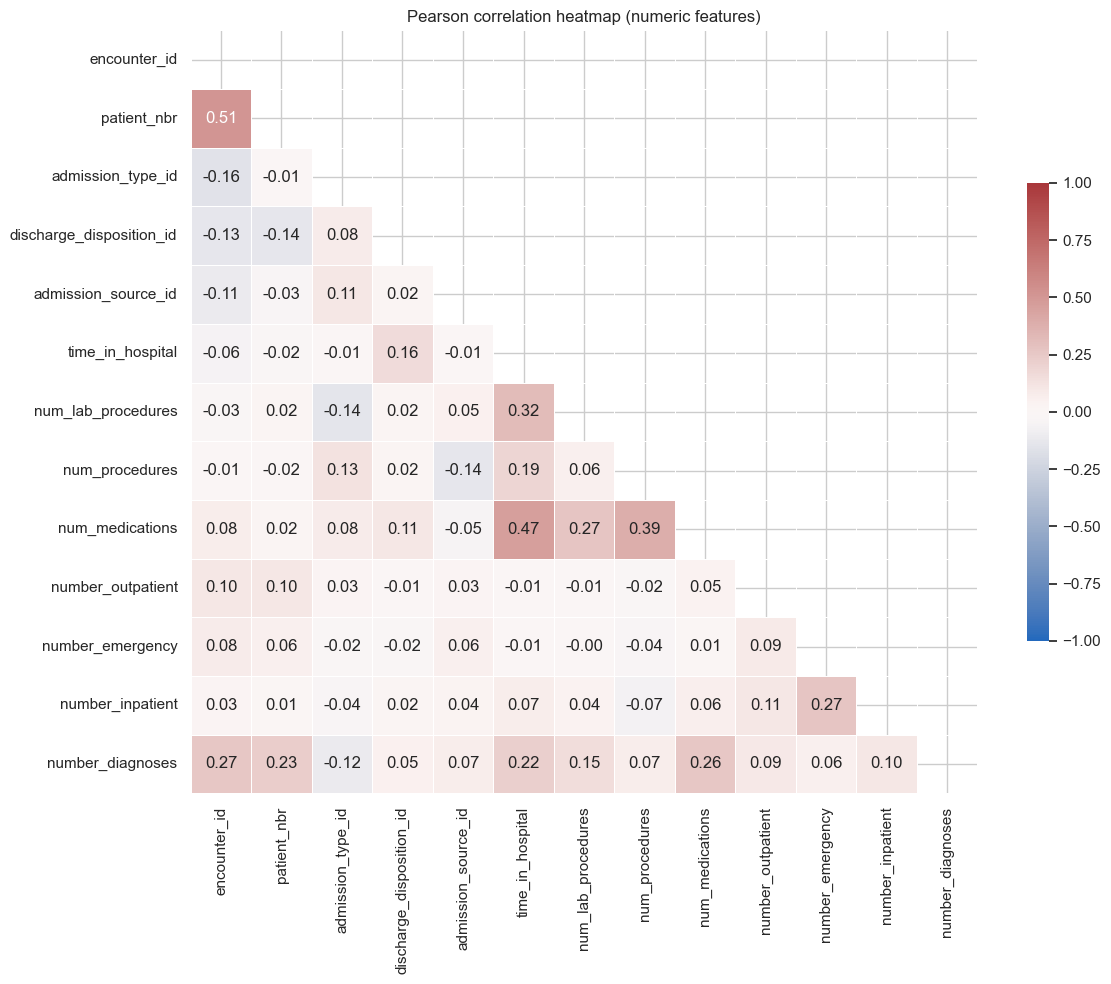

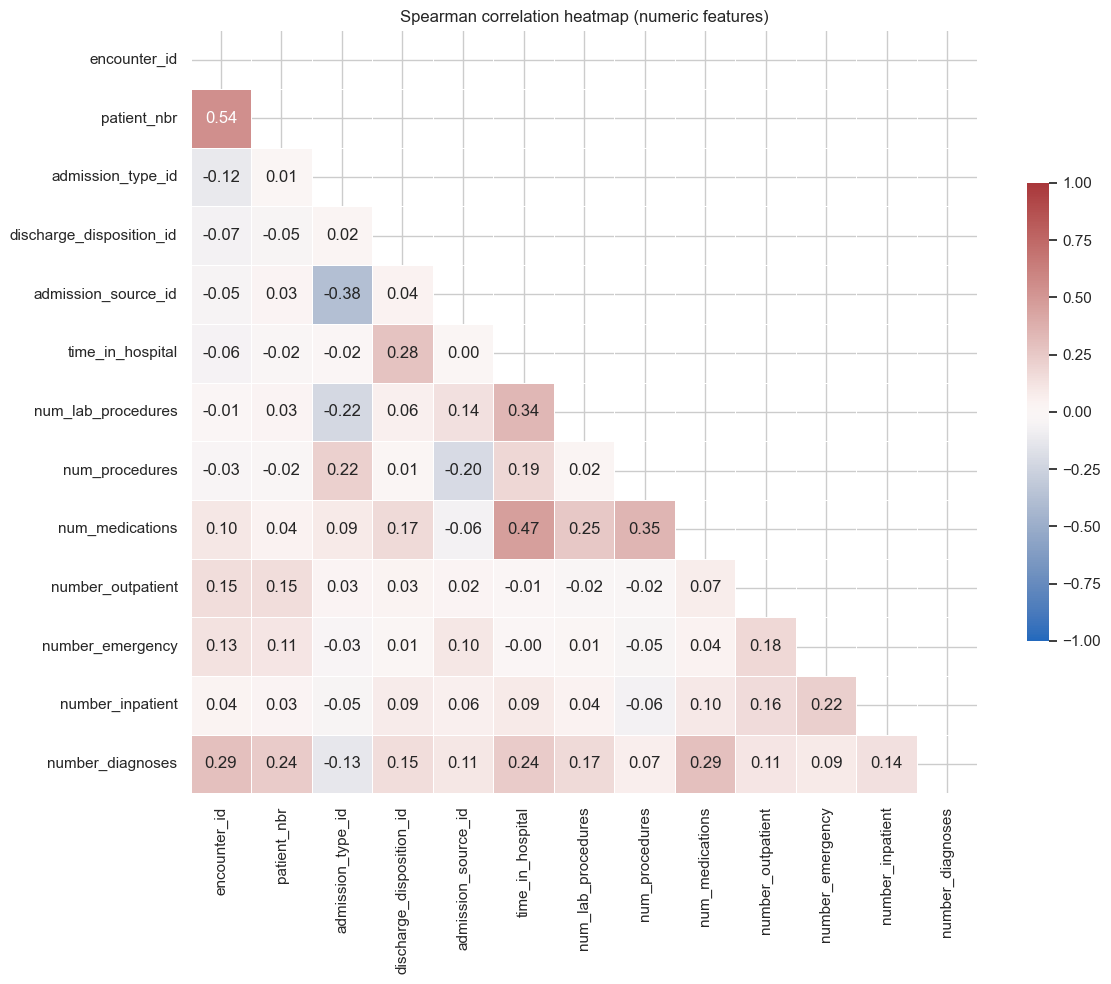

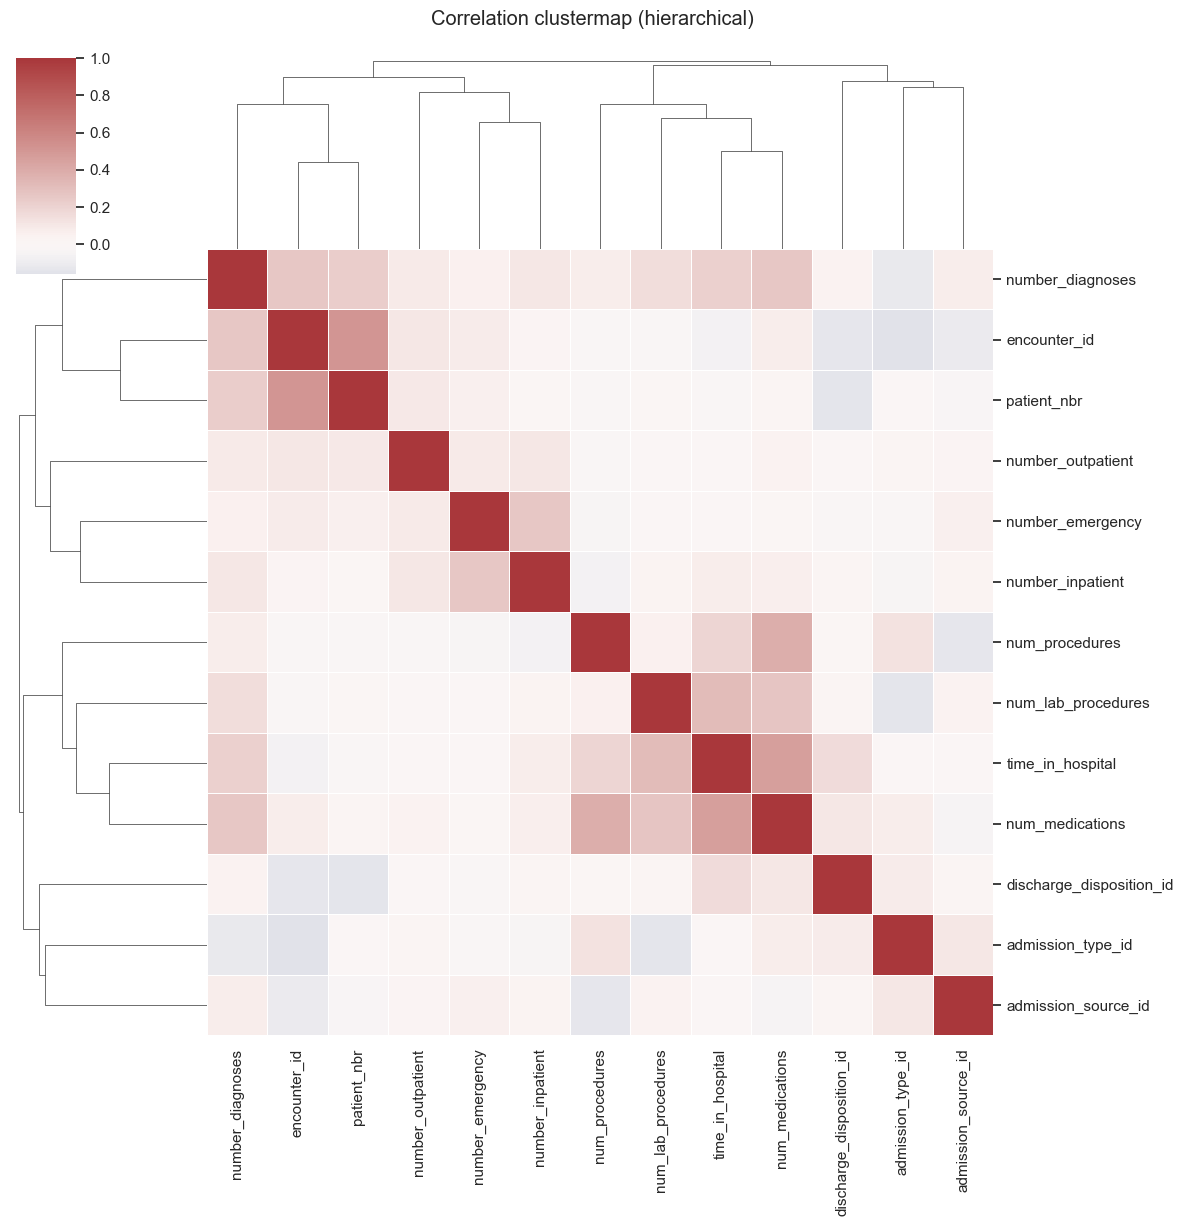

KeyboardInterrupt: 

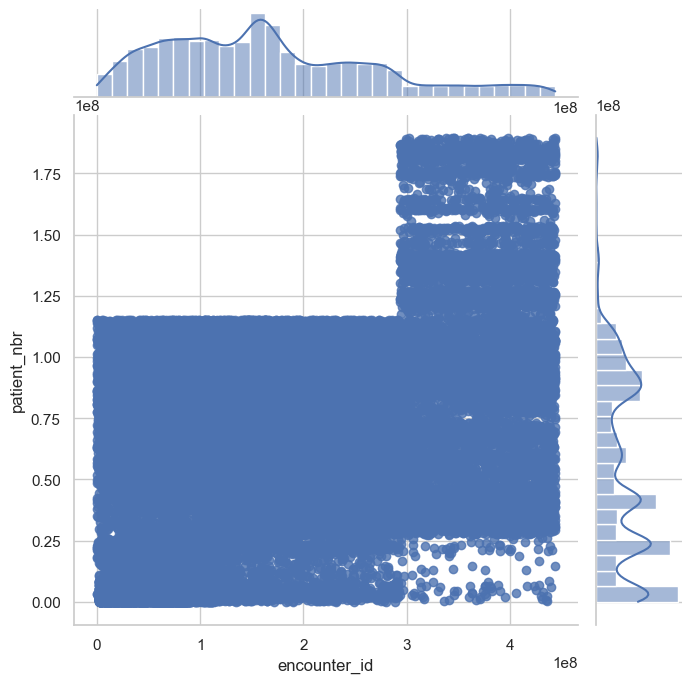

In [12]:

# Example usage: update DATA_PATH above if needed and run this cell to produce a set of correlation visualizations.
try:
    # attempt to load data; clear message printed by load_data on success
    df = load_data(DATA_PATH)
except FileNotFoundError as e:
    print(e)
    print("Edit DATA_PATH to point to your CSV and re-run this cell.")
else:
    # numeric correlation heatmaps (Pearson & Spearman)
    numeric_cols = compute_numeric_columns(df)
    # Limit number of numerics to a manageable size for plotting
    if len(numeric_cols) > 60:
        # pick top numeric columns by non-NA counts to avoid plotting extremely wide matrices
        numeric_cols = sorted(numeric_cols, key=lambda c: df[c].notna().sum(), reverse=True)[:60]
    corr_p = corr_matrix(df, cols=numeric_cols, method="pearson")
    plot_corr_heatmap(corr_p, title="Pearson correlation heatmap (numeric features)", fname=os.path.join(PLOT_DIR, "pearson_corr_heatmap.png"))
    corr_s = corr_matrix(df, cols=numeric_cols, method="spearman")
    plot_corr_heatmap(corr_s, title="Spearman correlation heatmap (numeric features)", fname=os.path.join(PLOT_DIR, "spearman_corr_heatmap.png"))

    # Clustermap to reveal correlated blocks
    try:
        plot_clustermap(corr_p, fname=os.path.join(PLOT_DIR, "corr_clustermap.png"))
    except Exception as e:
        print('Clustermap generation failed:', e)

    # Correlation with target (if target exists)
    if "readmit_30" in df.columns:
        corr_target_df = corr_with_target_table(df, target="readmit_30")
        corr_target_df.to_csv(os.path.join(PLOT_DIR, "correlations_with_target.csv"))
        print('\nTop correlations with readmit_30:')
        display(corr_target_df.head(30))

        # Pairplot for top features correlated with target (sampled for performance)
        top_feats = corr_target_df.head(6).index.tolist()
        if top_feats:
            pairplot_sample(df, cols=top_feats, hue="readmit_30", sample_frac=0.2, fname=os.path.join(PLOT_DIR, "pairplot_top_features.png"))

    # Example jointplot for two numeric features if they exist
    if len(numeric_cols) >= 2:
        x = numeric_cols[0]
        y = numeric_cols[1]
        jointplot_pair(df, x=x, y=y, hue=("readmit_30" if "readmit_30" in df.columns else None), kind="reg", fname=os.path.join(PLOT_DIR, "jointplot_example.png"))

    # Categorical vs target heatmaps for up to 4 categorical columns (static)
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if categorical_cols:
        categorical_correlation_heatmap(df, cat_cols=categorical_cols[:4], target=("readmit_30" if "readmit_30" in df.columns else None), fname=os.path.join(PLOT_DIR, "cat_target_heatmap.png"))
        # additionally launch interactive widget so user can explore arbitrary selections
        create_categorical_correlation_widget(df)

    # After prior analyses, compute per-feature associations with readmission-like target

    # detect likely readmission column(s)
    candidate_targets = ["readmit_30", "readmitted", "readmitted_30", "readmit"]
    target_col = next((c for c in candidate_targets if c in df.columns), None)

    if target_col:
        try:
            assoc_df = compute_feature_target_associations(df, target=target_col)
            # save and display the top associations
            out_csv = os.path.join(PLOT_DIR, f"associations_with_{target_col}.csv")
            assoc_df.to_csv(out_csv)
            print(f"\nTop associations with {target_col}:")
            display(assoc_df.head(30))
            print(f"Saved associations CSV to: {out_csv}")
        except Exception as e:
            print("Failed to compute associations with target:", e)
    else:
        print("No readmission candidate column found; skip feature->target association summary.")

    print(f"\nSaved correlation plots & CSVs to: {os.path.abspath(PLOT_DIR)}")

